# Lab Session: Building a Recommender System with LightFM

Lab Session: Building a Recommender System with LightFM

## Overview

In this lab session, we will go through the entire pipeline of building a recommender system. We will use the [H&M dataset released in a Kaggle competition](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations) and the [LightFM library](https://making.lyst.com/lightfm/docs/home.html). The session will cover data analysis, data sampling, model training, hyperparameter tuning, evaluation, and hybrid recommendation incorporating item features.

**Project Data** : [Available on Google Drive](https://drive.google.com/drive/folders/1Y7SJnwZp1KZxfYF64PqIM8drlQqJKezw)

## Dataset

Download the [H&M dataset from the Kaggle competition page](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations), or use the data available in the gdrive folder.

### Files needed

- transactions_train.csv
- articles.csv
- customers.csv

## Introduction to LightFM

### What is LightFM ?

LightFM is a Python library designed for building and evaluating recommender systems. It is particularly well-suited for handling hybrid recommendation scenarios that combine collaborative filtering with content-based methods. LightFM is known for its flexibility, allowing you to incorporate user and item metadata into the recommendation process, which can significantly improve the accuracy of your recommendations.

### Key Features of LightFM

1.	Flexible Hybrid Models: LightFM allows for the combination of collaborative and content-based filtering by integrating item and user features.
2.	Different Loss Functions: LightFM supports several loss functions for training models, including:
    - WARP (Weighted Approximate-Rank Pairwise): Optimizes for ranking quality, suitable for implicit feedback data.
    - BPR (Bayesian Personalized Ranking): Optimizes for pairwise ranking, commonly used in implicit feedback scenarios.
    - Logistic: Suitable for explicit feedback.
    - WARP-kos: A variant of WARP for use with highly sparse datasets.
3.	Scalability: Designed to efficiently handle large datasets.
4.	Ease of Use: Provides a simple and intuitive API for model training and evaluation.

### Components of a LightFM Model

1.	Interactions Matrix: Represents user-item interactions. In our case, it will be a sparse matrix where rows represent users and columns represent items, and the values represent interactions (e.g., purchases).
2.	User and Item Features: Optional matrices that include additional information about users and items. For this lab, we will incorporate item features to build a hybrid model.
3.	Loss Function: Defines how the model is trained. We will experiment with different loss functions to optimize our recommendations.

## Step-by-Step Guide

## Step 0 : Loading libraries and data

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define local paths
local_articles_path = Path("../data/raw/articles.csv").resolve()
local_customers_path = Path("../data/raw/customers.csv").resolve()
local_transactions_path = Path("../data/raw/transactions_train.csv").resolve()

# Remote URLs (GitHub)
# Fetch data from Kaggle (make sure you have access rights)
articles_url = "https://media.githubusercontent.com/media/auduvignac/" "..."
customers_url = "https://media.githubusercontent.com/media/auduvignac/" "..."
transactions_url = (
    "https://media.githubusercontent.com/media/auduvignac/" "..."
)


def load_dataset(local_path, url, name):
    """
    Loads a CSV file from a local path, or downloads it from a URL
    if the file does not exist locally.

    The file is then saved locally for future runs (fallback).

    Parameters
    ----------
    local_path : pathlib.Path
        Path to the local file.
    url : str
        Remote URL of the CSV file.
    name : str
        Display name shown during loading (used for logging).

    Returns
    -------
    pandas.DataFrame
        The contents of the CSV file as a DataFrame.
    """
    # Check if the local file exists
    if local_path.exists():
        print(f"{name} loaded from: {local_path}")
        return pd.read_csv(local_path)
    else:
        print(f"{name} not found locally, downloading from URL...")
        df = pd.read_csv(url)
        local_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(local_path, index=False)
        print(f"{name} downloaded and saved locally at: {local_path}")
        return df


# Load datasets
try:
    print("Loading datasets...")
    articles = load_dataset(local_articles_path, articles_url, "articles")
    customers = load_dataset(local_customers_path, customers_url, "customers")
    transactions = load_dataset(
        local_transactions_path, transactions_url, "transactions"
    )
    print("Datasets loaded successfully.\n")

except Exception as e:
    print("Failed to load datasets.")
    print("Check the validity of the URLs or your internet connection.")
    print(e)

Loading datasets...
articles loaded from: /home/aurelien/workspace/building-recommender-with-lightfm/data/raw/articles.csv
customers loaded from: /home/aurelien/workspace/building-recommender-with-lightfm/data/raw/customers.csv
transactions loaded from: /home/aurelien/workspace/building-recommender-with-lightfm/data/raw/transactions_train.csv
Datasets loaded successfully.



## Step 1: Data Exploration & Understanding

Objective: Get familiar with the H&M dataset structure and characteristics.

### What does the interaction data look like ? How many unique users and items do we have ?

In [3]:
# Count unique users and unique items
num_unique_users = transactions['customer_id'].nunique()
num_unique_items = transactions['article_id'].nunique()

print(f"Number of unique users: {num_unique_users}")
print(f"Number of unique items: {num_unique_items}")

Number of unique users: 1362281
Number of unique items: 104547


### What's the sparsity of the dataset ? (Compare total possible interactions vs actual interactions)

#### Sparsity

**Sparsity** refers to how few interactions exist compared to the total number of possible interactions between users and items.

In the context of this dataset:

> **Sparsity = 1 − (Number of actual interactions) / (Number of possible interactions)**

Where:
- **Actual interactions**: total number of rows in `transactions_train.csv`  
- **Possible interactions**: number of unique users $\times$ number of unique items

A high sparsity (close to 1) means that most users have interacted with only a small fraction of the available items — which is typical in real-world recommendation scenarios.

Understanding sparsity is important because:
- It highlights the challenge of limited interaction data.
- It justifies the use of models like **LightFM**, which are designed to work well with sparse user–item matrices.

In [ ]:
# Actual interactions
num_interactions = len(transactions)

# Total possible interactions
# num_unique_users number of unique users
# num_unique_items number of unique items
# total_possible_interactions = num_unique_users * num_unique_items
# This assumes each user could potentially interact with every item.
# In practice, this is often much larger than the actual number of interactions.
total_possible_interactions = num_unique_users * num_unique_items

# Sparsity
sparsity = 1 - (num_interactions / total_possible_interactions)

print(f"Unique users: {num_unique_users}")
print(f"Unique items: {num_unique_items}")
print(f"Actual interactions: {num_interactions}")
print(f"Total possible interactions: {total_possible_interactions}")
print(f"Dataset sparsity: {sparsity:.6f}")

Unique users: 1362281
Unique items: 104547
Actual interactions: 31788324
Total possible interactions: 142422391707
Dataset sparsity: 0.999777


#### Sparsity Analysis

- **Unique users**: 1 362 281  
- **Unique items**: 104 547  
- **Actual interactions**: 31 788 324  
- **Total possible interactions** (users $\times$ items): 142 422 391 707  
- **Dataset sparsity**: **0.999777** ($\approx$ 99.98%)

#### Interpretation

This dataset is **extremely sparse**, with only about **0.022%** of possible user–item interactions actually observed.

#### Explanation and hypothesis

- In real-world e-commerce, users interact with **only a tiny fraction** of the catalog ;
- Most users buy a handful of items, and many items are **never interacted with** by the majority of users.

#### Implications for modeling:
- Traditional recommendation models (e.g., matrix factorization) may struggle without techniques to handle sparsity.
- **LightFM** is a good fit because it can incorporate:
  - **Collaborative filtering** (based on interactions)
  - **Content-based features** (like item metadata)
- Cold-start problems are likely present, especially for new or rare items.


### How are interactions distributed across users and items ? Are there power users or blockbuster items ?

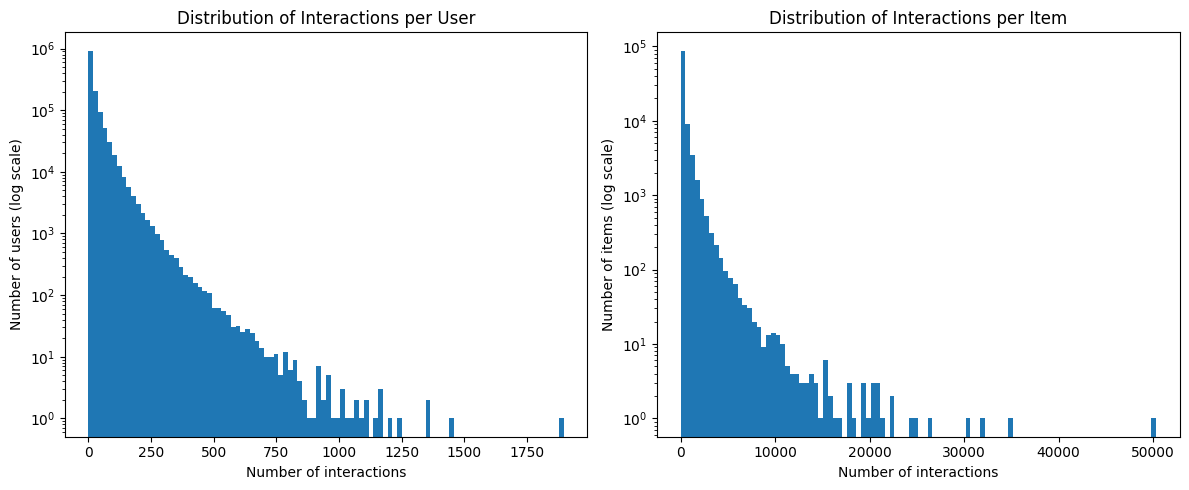

In [5]:
# Count interactions per user and per item
user_interactions = transactions['customer_id'].value_counts()
item_interactions = transactions['article_id'].value_counts()

# Plot interaction distributions
plt.figure(figsize=(12, 5))

# User interactions
plt.subplot(1, 2, 1)
plt.hist(user_interactions, bins=100, log=True)
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of interactions")
plt.ylabel("Number of users (log scale)")

# Item interactions
plt.subplot(1, 2, 2)
plt.hist(item_interactions, bins=100, log=True)
plt.title("Distribution of Interactions per Item")
plt.xlabel("Number of interactions")
plt.ylabel("Number of items (log scale)")

plt.tight_layout()
plt.show()

#### Interaction Distribution Analysis

The histograms above show how interactions are distributed across users and items, on a log scale:

##### Distribution per User (Left Plot)

- The vast majority of users have **very few interactions** — most made only a handful of purchases.
- A **long tail of power users** exists: a small number of users made **hundreds or even thousands** of purchases.
- This right-skewed pattern is typical in e-commerce datasets.

##### Distribution per Item (Right Plot)

- Similarly, most items were purchased **only a few times**.
- A small number of **blockbuster items** were purchased tens of thousands of times.
- These likely represent **best-sellers**, seasonal items, or heavily promoted products.

##### Implications

- The dataset exhibits a **strong long-tail behavior** for both users and items.
- **Collaborative filtering alone** may over-focus on power users and popular items.
- Including **item features** (e.g., product type, category, color) in a **hybrid model** is recommended to improve diversity and personalization.


- What time period does the data cover? Are there seasonal patterns?
- What metadata is available for items and customers ?

Suggested Analyses:
- Plot distribution of interactions per user and per item (histograms, box plots)
- Identify the long tail: what percentage of items/users account for 80% of interactions ?
- Examine the most and least popular items - what patterns do you notice ?
- Think about: How might these patterns affect your recommendation strategy ?